In [223]:
%load_ext autoreload
%autoreload 2

import src.ksd.models as models
from src.ksd.find_modes import find_modes, pairwise_directions, run_bfgs
from src.ksd.langevin import RandomWalkMH, RandomWalkBarker
import src.ksd.langevin as mcmc
from src.ksd.ksd import KSD, SDEKSD, GKSD
from src.ksd.kernel import IMQ
from src.ksd.bootstrap import Bootstrap
from src.ksd.find_modes import find_modes, pairwise_directions
from tqdm.notebook import tqdm, trange

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import seaborn as sns

import src.kgof.density as density
import src.kgof.data as data

MCMCKernel = RandomWalkMH # RandomWalkBarker

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [224]:
tf.random.set_seed(1)

In [225]:
class LimitingDistribution:
    def __init__(self, init_log_prob, target_log_prob, nu):
        self.init_log_prob = init_log_prob
        self.target_log_prob = target_log_prob
        self.nu = nu
        
    def log_prob(self, x, k=100):
        xp = tf.expand_dims(x, axis=0) + tf.cast(
            self.nu * tf.reshape(
                tf.linspace(-k//2, k//2, k+1), 
                (-1, 1, 1),
            ), 
            dtype=tf.float32
        )
        
        term1 = self.target_log_prob(x) # n, 1
        
        weight_numerator = self.init_log_prob(xp) # k, n, 1
        weight_numerator = tf.math.reduce_logsumexp(weight_numerator, axis=0) # n, 1
        
        weight_denom = self.target_log_prob(xp) # k, n, 1
        weight_denom = tf.math.reduce_logsumexp(weight_denom, axis=0) # n, 1
        
        log_prob = term1 + weight_numerator - weight_denom # n, 1
        
        return log_prob
        

In [226]:
dim = 1 # has to be 1

## mixure of gaussians
k = 1
delta = 10.
shift = 0. # [- delta / 2]
ratio_sample = 1.
ratio_target = 0.5

target, log_prob_fn = models.create_mixture_gaussian_kdim(
    dim=dim, k=k, delta=delta, shift=shift, return_logprob=True, ratio=ratio_target)
proposal_off, log_prob_off_fn = models.create_mixture_gaussian_kdim(
    dim=dim, k=k, delta=delta, shift=shift, return_logprob=True, ratio=ratio_sample)


In [227]:
target_sample = target.sample(1000)
proposal_sample = proposal_off.sample(1000)

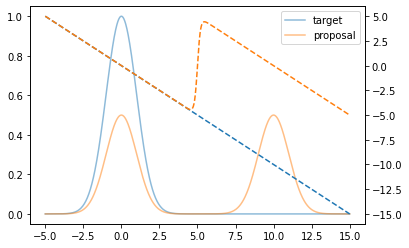

In [228]:
xx = tf.reshape(tf.linspace(-5., delta+5., 1000), (-1, 1))

with tf.GradientTape() as g:
    g.watch(xx)
    lp = log_prob_fn(xx)
score_target = g.gradient(lp, xx)

with tf.GradientTape() as g:
    g.watch(xx)
    lp = log_prob_off_fn(xx)
score_proposal = g.gradient(lp, xx)

fig, ax1 = plt.subplots()
ax1.plot(xx.numpy(), tf.math.exp(log_prob_off_fn(xx)).numpy(), label="target", alpha=0.5)
ax1.plot(xx.numpy(), tf.math.exp(log_prob_fn(xx)).numpy(), label="proposal", alpha=0.5)

ax2 = ax1.twinx()
ax2.plot(xx.numpy(), score_proposal.numpy(), linestyle="--")
ax2.plot(xx.numpy(), score_target.numpy(), linestyle="--")

ax1.legend()
plt.show()

In [229]:
def plot_scores(log_prob_fn, log_prob_off_fn, nu_delta_ratios, delta, nrows, ncols, plot_diff=False):
    xx = tf.reshape(tf.linspace(-5., delta+5., 1000), (-1, 1))

    figs, axes = plt.subplots(nrows, ncols, figsize=(20, 10))
    for j, ratio in enumerate(nu_delta_ratios):
        nu = ratio * delta
        
        # target
        limiting_target = LimitingDistribution(log_prob_fn, log_prob_fn, nu)
        
        with tf.GradientTape() as g:
            g.watch(xx)
            lp_target = limiting_target.log_prob(xx)
        prob_target = tf.math.exp(lp_target)
        score_target = g.gradient(lp_target, xx)
        
        # proposal
        limiting_proposal = LimitingDistribution(log_prob_off_fn, log_prob_fn, nu)
        
        with tf.GradientTape() as g:
            g.watch(xx)
            lp_proposal = limiting_proposal.log_prob(xx)
        prob_proposal = tf.math.exp(lp_proposal)
        score_proposal = g.gradient(lp_proposal, xx)
        
        # score differences
        score_diff = tf.reshape(
            tf.math.abs(score_target - score_proposal),
            (-1,),
        )
        
        # density
        axes[j//ncols][j%ncols].plot(xx, prob_target, label="target")
        axes[j//ncols][j%ncols].plot(xx, prob_proposal, label="proposal")
        axes[j//ncols][j%ncols].set_ylim(-.05, 1.1)
        
        # score
        ax_twin = axes[j//ncols][j%ncols].twinx()
        if not plot_diff:
            ax_twin.plot(xx, score_target, linestyle="--")
            ax_twin.plot(xx, score_proposal, linestyle="--")
            ax_twin.set_ylim(-delta, delta)
        else:
            ax_twin.plot(xx, score_diff, linestyle="--", color="red", label="abs score diff")
            ax_twin.set_ylim(-0.5, 15.)
    
        axes[j//ncols][j%ncols].set_title(f"nu / Delta = {np.round(ratio, 3)}")
    
    axes[0][0].legend()
    plt.tight_layout()

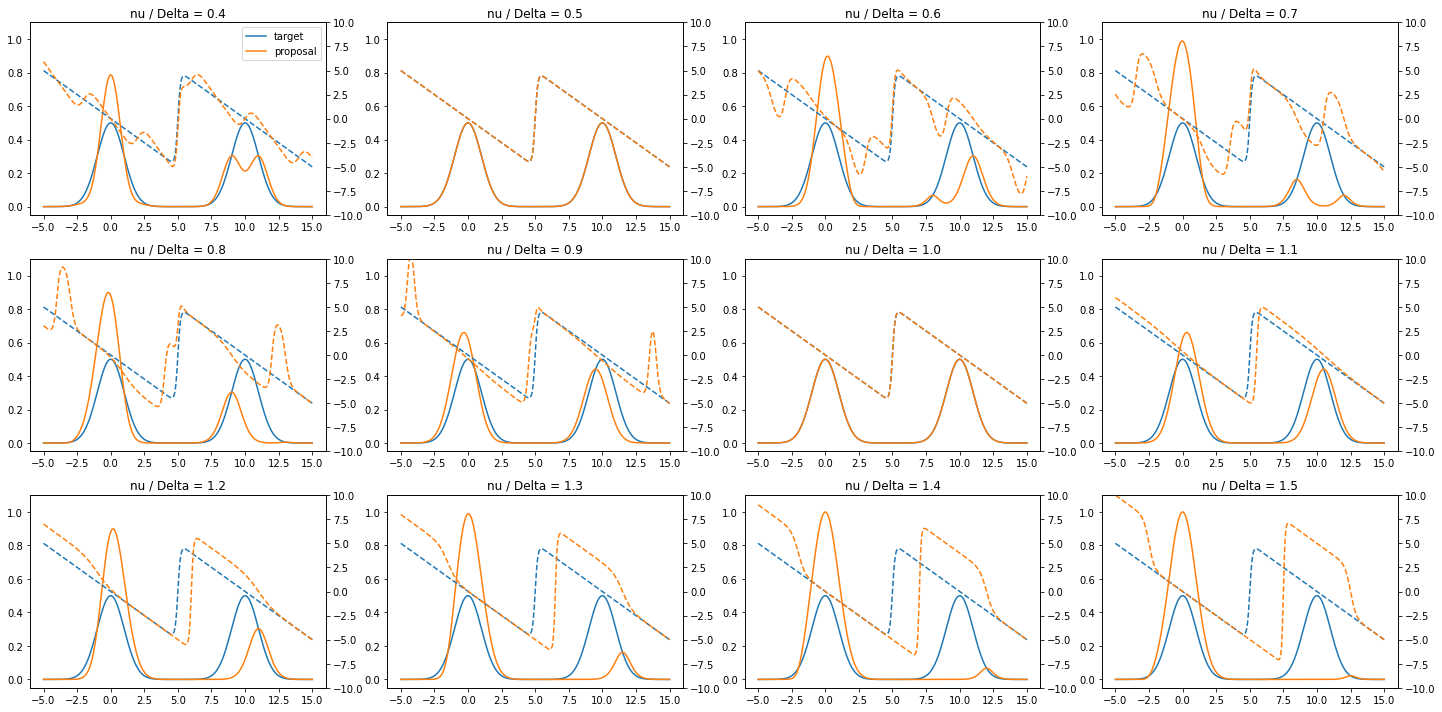

In [230]:
nu_delta_ratios = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]
# nu_delta_ratios = list(np.linspace(0.05, 0.4, 12))
nu_delta_ratios = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]

plot_scores(
    log_prob_fn=log_prob_fn, 
    log_prob_off_fn=log_prob_off_fn, 
    nu_delta_ratios=nu_delta_ratios,
    delta=delta,
    nrows=3, 
    ncols=4,
)

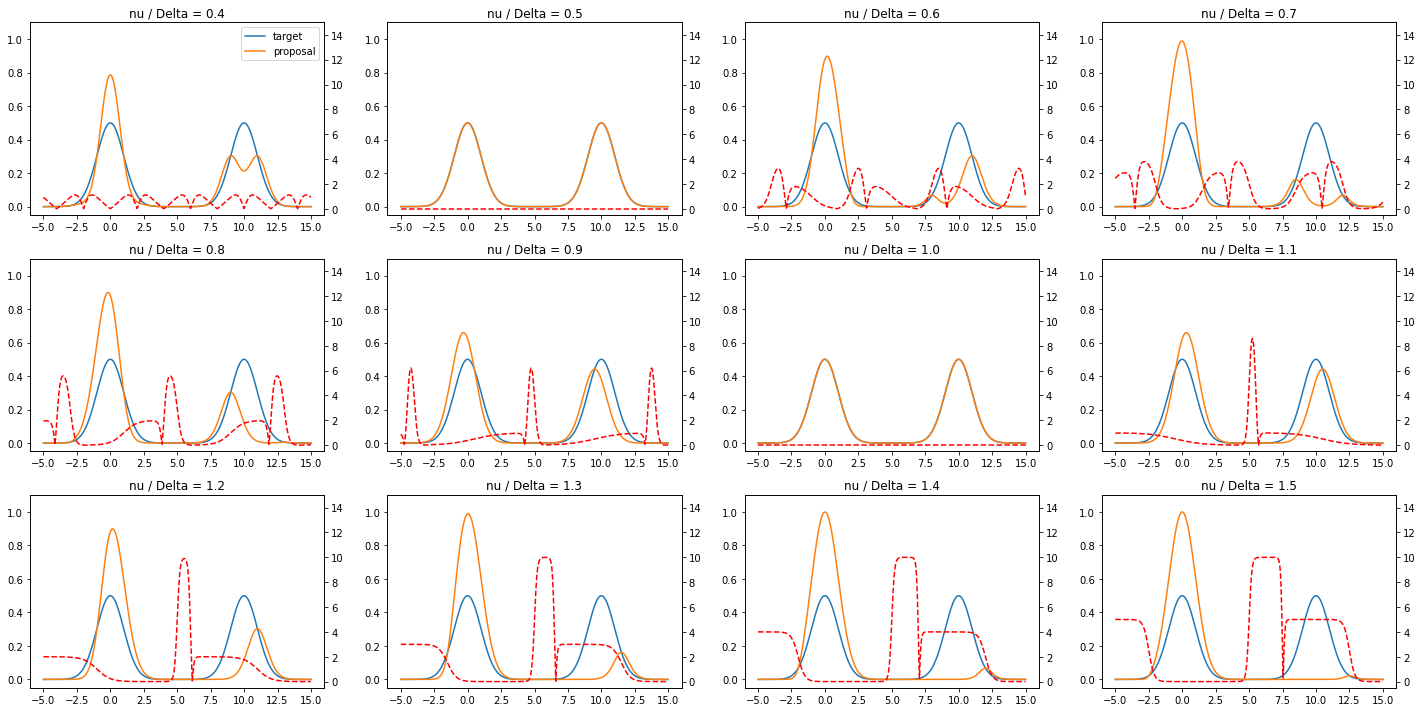

In [231]:
nu_delta_ratios = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]

plot_scores(
    log_prob_fn=log_prob_fn, 
    log_prob_off_fn=log_prob_off_fn, 
    nu_delta_ratios=nu_delta_ratios,
    delta=delta,
    nrows=3, 
    ncols=4,
    plot_diff=True,
)

In [232]:
def plot_weighted_scores(log_prob_fn, log_prob_off_fn, nu_delta_ratios, delta, nrows, ncols):
    xx = tf.reshape(tf.linspace(-5., delta+5., 1000), (-1, 1))
    delta_x = xx[1, 0] - xx[0, 0]
    fisher_div_list = []
    
    figs, axes = plt.subplots(nrows, ncols, figsize=(20, 10))
    for j, ratio in enumerate(nu_delta_ratios):
        nu = ratio * delta
        
        # target
        limiting_target = LimitingDistribution(log_prob_fn, log_prob_fn, nu)
        
        with tf.GradientTape() as g:
            g.watch(xx)
            lp_target = limiting_target.log_prob(xx)
        prob_target = tf.math.exp(lp_target)
        score_target = g.gradient(lp_target, xx)
        
        # proposal
        limiting_proposal = LimitingDistribution(log_prob_off_fn, log_prob_fn, nu)
        
        with tf.GradientTape() as g:
            g.watch(xx)
            lp_proposal = limiting_proposal.log_prob(xx)
        prob_proposal = tf.math.exp(lp_proposal)
        score_proposal = g.gradient(lp_proposal, xx)
        
        # weighted score differences
        weighted_score_diff = prob_proposal * tf.reshape(
            tf.math.abs(score_target - score_proposal),
            (-1,),
        )
        
        # Fisher div
        fisher_div = tf.math.reduce_sum(weighted_score_diff[:-2] * delta_x)
        fisher_div_list.append(fisher_div)

        # plot
        axes[j//ncols][j%ncols].plot(
            xx, weighted_score_diff, linestyle="--", color="red", label="weighted score diff",
        )
        axes[j//ncols][j%ncols].set_ylim(-.05, 0.5)
        axes[j//ncols][j%ncols].set_title(f"nu / Delta = {np.round(ratio, 3)}")
    
    axes[0][0].legend()
    plt.tight_layout()
    plt.show()


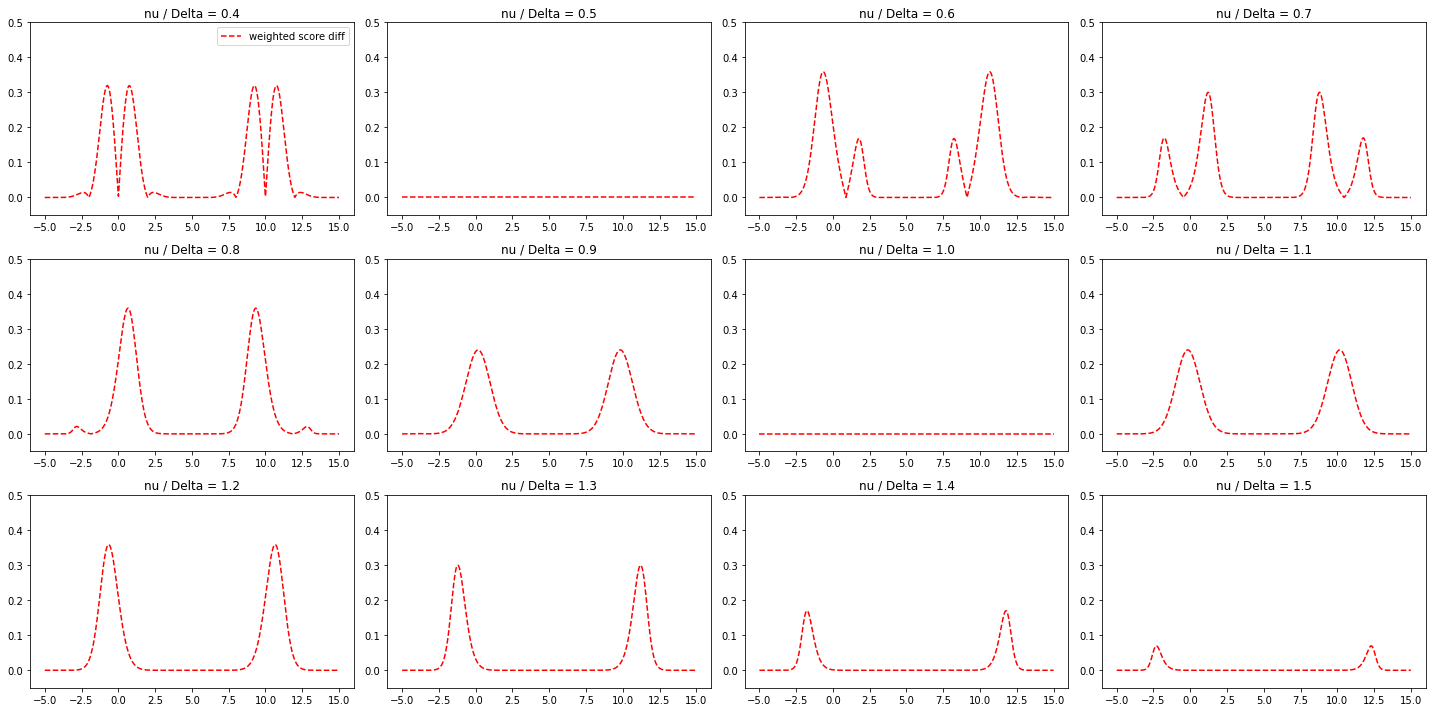

In [233]:
nu_delta_ratios = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]

plot_weighted_scores(
    log_prob_fn=log_prob_fn, 
    log_prob_off_fn=log_prob_off_fn, 
    nu_delta_ratios=nu_delta_ratios,
    delta=delta,
    nrows=3, 
    ncols=4,
)

In [234]:
def plot_discrepancy(
    log_prob_fn, log_prob_off_fn, proposal_sample, 
     nu_delta_ratios, delta, proposal_dict, ind_pair_list,
     T=1000,
):
    delta_x = xx[1, 0] - xx[0, 0]
    fisher_div_list = []
    ksd_list = []
    accept_rate_list = []
    
    # perturb
    mh = mcmc.RandomWalkMH(log_prob=log_prob_fn)
    mh.run(steps=T, std=nu_delta_ratios, x_init=proposal_sample, ind_pair_list=ind_pair_list, **proposal_dict)
    
    # compute KSD of un-perturbed
    kernel = IMQ(med_heuristic=True)
    ksd = KSD(kernel=kernel, log_prob=log_prob_fn)
    x_0 = mh.x[0, 0]
    ksd_val_unpert = ksd(x_0, tf.identity(x_0))
    
    figs, axes = plt.subplots(1, 2, figsize=(12, 4))
    for j, ratio in enumerate(nu_delta_ratios):
        nu = ratio * delta
        
        # get perturbed data
        x_t = mh.x[j, -1]

        # 1. compute KSD
        kernel = IMQ(med_heuristic=True)
        ksd = KSD(kernel=kernel, log_prob=log_prob_fn)
        ksd_val = ksd(x_t, tf.identity(x_t))
        ksd_list.append(ksd_val)
        
        # 2. compute Fisher div
        # target
        limiting_target = LimitingDistribution(log_prob_fn, log_prob_fn, nu)
        
        with tf.GradientTape() as g:
            g.watch(x_t)
            lp_target = limiting_target.log_prob(x_t)
        prob_target = tf.math.exp(lp_target)
        score_target = g.gradient(lp_target, x_t)
        
        # proposal
        limiting_proposal = LimitingDistribution(log_prob_off_fn, log_prob_fn, nu)
        
        with tf.GradientTape() as g:
            g.watch(x_t)
            lp_proposal = limiting_proposal.log_prob(x_t)
        prob_proposal = tf.math.exp(lp_proposal)
        score_proposal = g.gradient(lp_proposal, x_t)
        
        # Fisher div
        fisher_div = tf.math.reduce_mean(
            (score_target - score_proposal)**2,
        )
        fisher_div_list.append(fisher_div)
        
    # plot
    pl1 = axes[0].plot(nu_delta_ratios, ksd_list, marker=".", markersize=12, label="pKSD")
    pl1 = axes[0].plot(nu_delta_ratios, fisher_div_list, marker=".", markersize=12, label="Fisher divergence")
    axes[0].axhline(ksd_val_unpert, color="grey", linestyle="dashed", label="pKSD unperturbed")
    axes[0].set_xlabel("nu / Delta", fontsize=18)
    axes[0].set_ylabel("Divergence", fontsize=18)
    axes[0].xaxis.set_tick_params(labelsize=18)
    axes[0].yaxis.set_tick_params(labelsize=18)
    
    axes[0].legend(fontsize=16, loc="upper right")

#     ax_twin = ax.twinx()
#     pl2 = ax_twin.plot(
#         nu_delta_ratios, fisher_div_list, linestyle="--", color="red", marker=".", label="Fisher divergence"
#     )
#     ax_twin.set_ylabel("Fisher divergence", fontsize=18)
#     ax_twin.yaxis.set_tick_params(labelsize=18)

#     lns = pl1 + pl2
#     labs = [l.get_label() for l in lns]
#     ax.legend(lns, labs)
    
    # acceptance rate
    accept_rate = tf.math.reduce_mean(mh.if_accept, axis=[1, 2])
    axes[1].plot(nu_delta_ratios, accept_rate, marker=".", markersize=12, color="k")
    axes[1].set_xlabel("nu / Delta", fontsize=18)
    axes[1].set_ylabel("Average acceptance rate", fontsize=18)

    plt.tight_layout()
    plt.show()

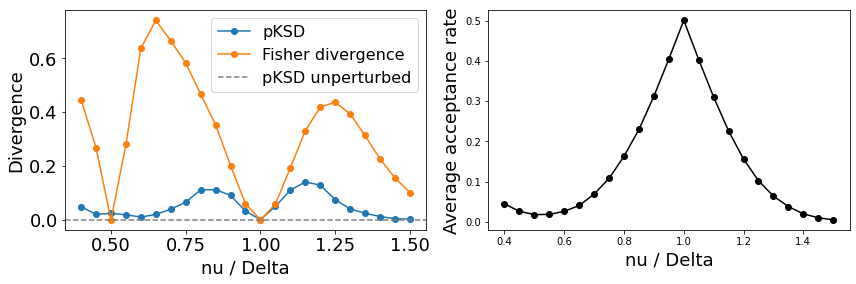

In [238]:
# modes and hess
mode_list = [tf.constant([0.]), tf.constant([delta])]
inv_hess_list = [tf.eye(1), tf.eye(1)]

proposal_dict = mcmc.prepare_proposal_input_all(
    mode_list=mode_list,
    inv_hess_list=inv_hess_list,
)

_, ind_pair_list = pairwise_directions(mode_list, return_index=True)

# ratios
nu_delta_ratios = [float(x) for x in np.linspace(0.4, 1.5, 23)]

plot_discrepancy(
    log_prob_fn=log_prob_fn,
    log_prob_off_fn=log_prob_off_fn,
    proposal_sample=proposal_sample, 
    nu_delta_ratios=nu_delta_ratios, 
    delta=delta, 
    proposal_dict=proposal_dict, 
    ind_pair_list=ind_pair_list,
    T=1000,
)